In [9]:
import re
import os
import sys
import pymbar
import natsort
import itertools
import numpy as np
import pandas as pd
from copy import copy
from glob import glob
from scipy import integrate
import scipy.optimize as opt
from pymbar import timeseries
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter

In [36]:
pymbar.__version__

'4.0.1'

In [46]:
class ARW_FE_analysis():
    '''New idea: do an if statement in the readpmd method. also try to use codeaesthetics method to denest the whole thing.
the if statement should check the length of the cv columns list and execute the method regularly if length==1. Then return. Else,
Exectute the same function for all columns of the list. And collect them in lists for processing them with multi cv mbar methode 
still to be written. The regex need to be formatted adhoc instead of at the init statement. The multi col method needs 
a forloop over the cv sample list and assigns Hamiltonians_CVs for each column that is then used in decorr and for
Energy calculation.'''        

    def __init__(self, fileglob, CV_columnList, T, nbins, subset=0): ### CVcolumnsList
        self.subset = subset
        self.kB = 0.001987204259       # kB in kcal/mol/K ambers standard energy unit
        self.Temperature = T
        self.Beta = 1.0 / (self.kB * self.Temperature)
        self.files = glob(fileglob)
        self.hamiltonians = len(self.files)
        self.hamiltonianTemperatures = np.ones(self.hamiltonians,float)*T
        self.CV_columnList = CV_columnList
        self.CV_columnCount = len(CV_columnList)
        self.hamiltonianBetas = 1.0 / (self.kB * self.hamiltonianTemperatures)
        self.hamiltoniansAnchorPattern = r'anchor\({}\).* position = .?\d*.\d+,\s+(.?\d*.\d*),\s+(.?\d*.\d+),\s+.?\d*.\d+'
        self.hamiltoniansForceRegex = re.compile(r'strength = (\d*.\d+),\s+(\d*.\d*)')
        self.hamiltonianForces = np.zeros(self.hamiltonians, np.float64) 
        self.hamiltonianAnchors = np.zeros(self.hamiltonians, np.float64)
        self.Hamiltonians_CVs = 0
        self.hamiltonianSamplesizes = 0
        self.cvmin = 0
        self.cvmax = 0
        self.nbins = nbins
        
        
# 2. Read in data and meta data of files or Read in CV data
    def read_cvdata_from_pmdout(self):
        CV_rawlist = []
        CV_minimas = []
        CV_maximas = []
        
        if self.CV_columnCount == 1:
            hamiltoniansAnchorRegex = re.compile(self.hamiltoniansAnchorPattern.format(self.CV_columnList[0]))

            # iterate through files to read the meta data (centers and spring constants)
            for i, CV_outputFile in enumerate(self.files):
                print('reading file with the filename {}'.format(CV_outputFile))
                # read the file and try to find the regex expression in each line
                with open(CV_outputFile) as fn:
                    for line in fn:
                        try:
                            cvAnchor1, cvAnchor2 = re.search(hamiltoniansAnchorRegex, line).group(1,2)
                            cvForce1, cvForce2 = re.search(self.hamiltoniansForceRegex, next(fn)).group(1,2)
                            self.hamiltonianAnchors[i] = float(cvAnchor1)
                            self.hamiltonianForces[i] = float(cvForce1)
                            break
                        except AttributeError:
                            # I forgot why this was important... but it was!
                            pass

                    if cvAnchor1 != cvAnchor2 or cvForce1 != cvForce2:
                        raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')

                CV_rawdata = pd.read_csv(CV_outputFile, 
                                         delim_whitespace=True,
                                         comment='#',
                                         header=None,
                                         usecols=self.CV_columnList) ### remove zero and brackets
                CV_rawlist.append(CV_rawdata.loc[:,self.CV_columnList[0]].values[-self.subset:]) 

                CV_minimas.append(CV_rawdata.loc[:,self.CV_columnList[0]].values.min())
                CV_maximas.append(CV_rawdata.loc[:,self.CV_columnList[0]].values.max())
            self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0))) #### For multicolumn, make sure to understand ziplongest(*list), because it is important how it handles CV_rawlist from 3 pandas columns
            self.hamiltonianSamplesizes = np.array([cv.shape[0] for cv in CV_rawlist])        
            collectiveVariableOrder = np.argsort(np.array([cv[cv != 0].mean() for cv in self.Hamiltonians_CVs]))

            self.Hamiltonians_CVs = self.Hamiltonians_CVs[collectiveVariableOrder]
            self.hamiltonianForces = self.hamiltonianForces[collectiveVariableOrder]
            self.hamiltonianAnchors = self.hamiltonianAnchors[collectiveVariableOrder]
            self.hamiltonianSamplesizes = self.hamiltonianSamplesizes[collectiveVariableOrder]
        
        if self.CV_columnCount > 1:
            Hamiltonians_CVs = []
            hamiltonianAnchors = []
            hamiltonianForces = []
            
            # iterate through files to read the meta data (centers and spring constants)
            for i, CV_outputFile in enumerate(self.files):
                print('reading file with the filename {}'.format(CV_outputFile))
                # read the file and try to find the regex expression in each line
                for CV_column in self.CV_columnList:
                    
                    hamiltoniansAnchorRegex = re.compile(self.hamiltoniansAnchorPattern.format(CV_column))
                    
                    with open(CV_outputFile) as fn:
                        for line in fn:
                            try:    
                                cvAnchor1, cvAnchor2 = re.search(hamiltoniansAnchorRegex, line).group(1,2)
                                cvForce1, cvForce2 = re.search(self.hamiltoniansForceRegex, next(fn)).group(1,2)
                                hamiltonianAnchors.append(float(cvAnchor1))
                                hamiltonianForces.append(float(cvForce1))
                                break
                            except AttributeError:
                                # I forgot why this was important... but it was!
                                pass

                    if cvAnchor1 != cvAnchor2 or cvForce1 != cvForce2:
                        raise ValueError('the reference positions r2, r3 or the force constants of each harmonic restraint contribution are not identical. WHAM only works for harmonic restraints. ')

                CV_rawdata = pd.read_csv(CV_outputFile, 
                                         delim_whitespace=True,
                                         comment='#',
                                         header=None,
                                         usecols=self.CV_columnList)
                CV_rawlist.append(CV_rawdata.loc[:,self.CV_columnList].values[-self.subset:].T) 

                CV_minimas.append(CV_rawdata.loc[:,self.CV_columnList].values.min())
                CV_maximas.append(CV_rawdata.loc[:,self.CV_columnList].values.max())
                 
            Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))
            flatHamiltonians_CVs = Hamiltonians_CVs.reshape(self.hamiltonians*self.CV_columnCount, -1)
            self.hamiltonianSamplesizes = np.array([cv.shape[0] for cv in flatHamiltonians_CVs])
            self.Hamiltonians_CVs = Hamiltonians_CVs.reshape(self.hamiltonians, self.CV_columnCount, -1)
            self.hamiltonianForces = np.array(hamiltonianForces).reshape(self.hamiltonians,-1)
            self.hamiltonianAnchors = np.array(hamiltonianAnchors).reshape(self.hamiltonians,-1)
        
# 2.5 Decorrelate data
    
    def logistic(self, x, a, k):   # logistc function is forced to cross the point (1,0) necessary for fitting a BSE curve
        return a / (1. + np.exp(-k * (x - 1)))-0.5*a
    
    def d2logistic_dx2(self, x, a, k):   # 2nd derivative of the logistic function above necessary for fitting a BSE curve
        return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
    
    def correlationTime_from_BSE(self, hamiltonian, minimumIndependentCVs=1000, showBSEplots=True):
        
        blockedStandardErrorsList = []

        CVs_hamiltonian = self.Hamiltonians_CVs[hamiltonian]
        CVs_hamiltonian = CVs_hamiltonian[CVs_hamiltonian != 0]
        
        CVsampleSize = CVs_hamiltonian.shape[0]
        maximumBlockSize = int(np.round(CVsampleSize / minimumIndependentCVs))

        for blockSize in range(1,maximumBlockSize):
            excludedSamples = CVsampleSize % blockSize   # to screen all integer blocksizes the first couple of CV sampes need to be excluded sometimes
            blockedAverages = np.mean(np.reshape(CVs_hamiltonian[excludedSamples:], (-1, blockSize)), axis=0)
            blockedStandardError = np.std(blockedAverages)
            blockedStandardErrorsList.append(blockedStandardError / np.sqrt(blockSize))

        BSE = np.array(blockedStandardErrorsList)
        blockSizes = np.arange(BSE.shape[0])

        (logisticAmplitude, logisticGrowthRate), _ = opt.curve_fit(self.logistic, blockSizes, BSE)
        BSE_fit = self.logistic(blockSizes,
                                logisticAmplitude,
                                logisticGrowthRate)
        BSE_fit_2nd_derivative = self.d2logistic_dx2(blockSizes, logisticAmplitude, logisticGrowthRate)
        correlationTimeEstimate = np.argsort(BSE_fit_2nd_derivative)[0]    # grossfield et al: t_corr = 2 * inflection_point; but whatever
        
        if showBSEplots:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            ax2 = ax.twinx()   # twin axis, since the second derivative is usually very small
            data = ax.plot(blockSizes, BSE, alpha=0.7, label='data')
            logfit = ax.plot(blockSizes, BSE_fit, label='logistic fit')
            gauss = ax.plot(blockSizes, gaussian_filter(BSE, sigma=10), linestyle='--', linewidth=0.7, label='gaussian smooth')
            deriv = ax2.plot(blockSizes, BSE_fit_2nd_derivative, c='r', linestyle='-.', label='2nd derivative')
            vline = ax.plot((correlationTimeEstimate, correlationTimeEstimate), (BSE.min(), BSE.max()),
                            linewidth=0.5,
                            color='black',
                            label='t_corr')

            lines = data+logfit+gauss+deriv+vline    # label collection crucial for ax.twinx()
            labels = [line.get_label() for line in lines]

            ax.set_title('BSE analysis for hamiltonian {} (t_corr={})'.format(hamiltonian,correlationTimeEstimate))
            ax.legend(lines, labels)
            plt.show()
            
        return correlationTimeEstimate

    
    ### I Think redoint this as a subclass makes sense or defining the variables as attributes which doesnt work becuz t_corr is hamiltonian wise scalar...
    def decorr_cv_H(self, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        hamiltoniansDecorrelatedSamplesizes = copy(self.hamiltonianSamplesizes)
        HamiltoniansDecorrelatedCVs = copy(self.Hamiltonians_CVs)
        
        if correlationTimeEstimate==None:
            ### maybe later, change this to for hamiltonian in range(self.hamiltonians * self.CVcolumnCount):
            for hamiltonian, _ in enumerate(self.Hamiltonians_CVs):
                correlationTimeEstimate = self.correlationTime_from_BSE(hamiltonian,
                                                                        minimumIndependentCVs=minimumIndependentCVs,
                                                                        showBSEplots=showBSEplots)                                
                decorrelatedCVsamplesize = int(self.hamiltonianSamplesizes[hamiltonian] / correlationTimeEstimate)
                highestCVsampleIndex = self.hamiltonianSamplesizes[hamiltonian]
                randomDecorrelatedIndices = np.random.randint(highestCVsampleIndex, size=decorrelatedCVsamplesize)
                hamiltoniansDecorrelatedSamplesizes[hamiltonian] = randomDecorrelatedIndices.shape[0]
                HamiltoniansDecorrelatedCVs[hamiltonian, 0:hamiltoniansDecorrelatedSamplesizes[hamiltonian]] = self.Hamiltonians_CVs[hamiltonian, randomDecorrelatedIndices]
                print("Correlation time for set {} is {}".format(hamiltonian, correlationTimeEstimate))
        else:
            ### maybe later, change this to for hamiltonian in range(self.hamiltonians * self.CVcolumnCount):
            for hamiltonian, _ in enumerate(self.Hamiltonians_CVs):
                decorrelatedCVsamplesize = int(hamiltoniansDecorrelatedSamplesizes[hamiltonian]/correlationTimeEstimate)
                highestCVsampleIndex = hamiltoniansDecorrelatedSamplesizes[hamiltonian]
                randomDecorrelatedIndices = np.random.randint(highestCVsampleIndex, size=decorrelatedCVsamplesize)
                hamiltoniansDecorrelatedSamplesizes[hamiltonian] = randomDecorrelatedIndices.shape[0]
                HamiltoniansDecorrelatedCVs[hamiltonian,:hamiltoniansDecorrelatedSamplesizes[hamiltonian]] = self.Hamiltonians_CVs[hamiltonian, randomDecorrelatedIndices]
                
        return HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes
            
        
# 3. calculate energies
    def calc_free_energies(self, decorrelationRequired=False, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        
        if decorrelationRequired:
            ### make them attributes and delete the else statement below; not necessary if indent is shifted one back
            HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs, 
                                                                                               correlationTimeEstimate=correlationTimeEstimate,
                                                                                               showBSEplots=showBSEplots)
            MaximumSampleSize = hamiltoniansDecorrelatedSamplesizes.max()
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None] 
                                        *self.hamiltonianForces[None,:, None]
                                        *(HamiltoniansDecorrelatedCVs[:,None,:MaximumSampleSize] - self.hamiltonianAnchors[:,None])**2)
    
            self.collectiveVariablesFlat = pymbar.utils.kn_to_n(HamiltoniansDecorrelatedCVs, N_k=hamiltoniansDecorrelatedSamplesizes)
            self.cvmin = np.ceil(self.collectiveVariablesFlat.min() * 100) / 100
            self.cvmax = np.floor(self.collectiveVariablesFlat.max() * 100) / 100

            self.bin_centers = np.linspace(self.cvmin, self.cvmax, self.nbins*2+1)[1::2]
            self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)
            
            self.histo_params = {}
            self.histo_params["bin_edges"] = self.bin_edges
            self.fes = pymbar.FES(Hamiltonians_CVs_energies,
                                  hamiltoniansDecorrelatedSamplesizes,
                                  verbose=True,
                                  mbar_options=dict(solver_protocol=solver_protocol))
        else:
            print("Caution, You might be using correlated Data.")
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None]
                                        *self.hamiltonianForces[None,:, None]
                                        *(self.Hamiltonians_CVs[:,None,:] - self.hamiltonianAnchors[:,None])**2)

            self.collectiveVariablesFlat = pymbar.utils.kn_to_n(self.Hamiltonians_CVs, N_k=self.hamiltonianSamplesizes)
            self.cvmin = np.ceil(self.collectiveVariablesFlat.min()*100)/100
            self.cvmax = np.floor(self.collectiveVariablesFlat.max()*100)/100

            self.bin_centers = np.linspace(self.cvmin,self.cvmax,self.nbins*2+1)[1::2]
            self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)

            self.histo_params = {}
            self.histo_params["bin_edges"] = self.bin_edges

            self.fes = pymbar.FES(Hamiltonians_CVs_energies,
                                  self.hamiltonianSamplesizes,
                                  verbose=True,
                                  mbar_options=dict(solver_protocol=solver_protocol))
        print("FES succesfully calculated")
    
    ### make one for multiCV calculations
    def calc_MBAR_free_energy_differences(self, angularData=False,decorrelationRequired=False, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        if angularData:
            self.Hamiltonians_CVs = np.exp(1j*self.Hamiltonians_CVs)
        
        ### this should just overwrite the prior data set instead  of creating a new variable.
        if decorrelationRequired:
            HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs, 
                                                                                               correlationTimeEstimate=correlationTimeEstimate,
                                                                                               showBSEplots=showBSEplots)
            MaximumSampleSize = hamiltoniansDecorrelatedSamplesizes.max()

            if angularData:
                Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None] 
                                            *self.hamiltonianForces[None,:, None]
                                            *np.angle(HamiltoniansDecorrelatedCVs[:,None,:MaximumSampleSize] / np.exp(1j*self.hamiltonianAnchors[:,None]))**2)
            else:
                Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None] 
                                            *self.hamiltonianForces[None,:,None]
                                            *(HamiltoniansDecorrelatedCVs[:,None,:MaximumSampleSize] - self.hamiltonianAnchors[:,None])**2)

            self.mbar = pymbar.MBAR(Hamiltonians_CVs_energies,
                                    hamiltoniansDecorrelatedSamplesizes,
                                    verbose=True,
                                    solver_protocol=solver_protocol)

            freeEnergyDifferences = self.mbar.compute_free_energy_differences()
            dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
            dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']

            Delta_F = dimensionlessDelta_F * self.kB * self.Temperature / 2
            Delta_F_Error = dimensionlessDelta_F_Error * self.kB * self.Temperature / 2
            ### I should make theses Attributes. They take no memory whatsoever
            return Delta_F, Delta_F_Error
        ### I should be able to delete this whole section, if I am just de-indenting the upper stuff after decorrelation if statement.
        ### proceed with caution though. 
        else:
            print("Caution, You might be using correlated Data.")
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None]
                                        *self.hamiltonianForces[None,:, None]
                                        *(self.Hamiltonians_CVs[:,None,:] - self.hamiltonianAnchors[:,None])**2)
            ### all this stuff is for PMFs not necessary for MBAR i guess
            self.collectiveVariablesFlat = pymbar.utils.kn_to_n(self.Hamiltonians_CVs, N_k=self.hamiltonianSamplesizes)
            self.cvmin = np.ceil(self.collectiveVariablesFlat.min()*100)/100
            self.cvmax = np.floor(self.collectiveVariablesFlat.max()*100)/100

            self.bin_centers = np.linspace(self.cvmin,self.cvmax,self.nbins*2+1)[1::2]
            self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)

            self.histo_params = {}
            self.histo_params["bin_edges"] = self.bin_edges
            
            self.mbar = pymbar.MBAR(Hamiltonians_CVs_energies,
                                    self.hamiltonianSamplesizes,
                                    verbose=True,
                                    solver_protocol=solver_protocol)
            
            freeEnergyDifferences = self.mbar.compute_free_energy_differences()
            dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
            dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']
            Delta_F = dimensionlessDelta_F * self.kB * self.Temperature / 2
            Delta_F_Error = dimensionlessDelta_F_Error * self.kB * self.Temperature / 2
            ### I should make theses Attributes. They take no memory whatsoever
            return Delta_F, Delta_F_Error
        
        
    def plot_histograms(self, angularData=False):
        if self.CV_columnCount == 1:
            for cvSamples in self.Hamiltonians_CVs:
                if angularData: cvSamples = np.angle(cvSamples)
                plt.hist(cvSamples[cvSamples != 0],bins=200,alpha=0.5)[2]
            plt.show()
            
        elif self.CV_columnCount > 1:
            for columnID in range(self.CV_columnCount):
                for cvSamples in self.Hamiltonians_CVs[:,columnID,:]:
                    if angularData: cvSamples = np.angle(cvSamples)
                    plt.hist(cvSamples[cvSamples != 0],bins=200,alpha=0.5)[2]
                plt.show()
                
        
        
# 5. Calculate FE
    def create_PMF(self, show_pmf=True):
        Hamiltonians_energies = (self.hamiltonianBetas[:, None]
                                *self.hamiltonianForces[:, None]
                                *(self.Hamiltonians_CVs[:,:] - self.hamiltonianAnchors[:, None])**2)
        
        Hamiltonians_energies -= Hamiltonians_energies.min()
        self.fes.generate_fes(Hamiltonians_energies, self.collectiveVariablesFlat, fes_type="histogram", histogram_parameters=self.histo_params)
        MBARFreeEnergySurface = self.fes.get_fes(self.bin_centers, reference_point="from-lowest", uncertainty_method="analytical")
        
        ### better naming, i.e. dimensionlessPMF instead of center_f_i
        center_f_i = MBARFreeEnergySurface["f_i"]
        center_df_i = MBARFreeEnergySurface["df_i"]
        
        self.reactionCoordinate = self.bin_centers
        self.PMF = center_f_i * self.kB * self.Temperature / 2
        self.dPMF = center_df_i * self.kB * self.Temperature / 2
        
        if show_pmf:
            plt.errorbar(self.reactionCoordinate, self.PMF, yerr=self.dPMF)
            plt.show()
        
    def calculate_I_star(self, dissociationBoundary=None, show_pmf=True):

        if dissociationBoundary==None:
            print("dissociationBoundary is None but should be the cut-off, where binding site ends and the bulk region starts")

        cvBinCenters, freeEnergy, freeEnergyError = self.create_PMF(show_pmf=show_pmf)
        dissociationBoundaryIndex = np.where(cvBinCenters > dissociationBoundary)[0][0]
        
        cvBinCenters[dissociationBoundaryIndex]
        Work_DissociationBoundary = freeEnergy[dissociationBoundaryIndex]
        Work_PMF = freeEnergy[:dissociationBoundaryIndex]

        boltzmannFactorDissociationWork = np.exp(-np.mean(self.hamiltonianBetas)*(W_PMF - W_site))
        I_star = integrate.trapz(boltzmannFactorDissociationWork, 
                                 self.bin_centers[:dissociationBoundaryIndex])
        
        setattr(self,'I_star', I_star)
        
    def compute_overlap_matrix(self, minimumIndependentCVs=100, correlationTimeEstimate=100, showBSEplots=False):
        
        try:
            MbarOverlap = self.mbar.compute_overlap()
            plt.matshow(MbarOverlap['matrix'], vmin=0, vmax=1)
            return MbarOverlap
        
        except AttributeError:
            
            HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs,
                                                                                                correlationTimeEstimate=correlationTimeEstimate,
                                                                                                showBSEplots=showBSEplots)
            MaximumSampleSize = hamiltoniansDecorrelatedSamplesizes.max()
            # cv_sort = np.argsort(self.cvs_H.mean(axis=1))
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None]
                                        *self.hamiltonianForces[None,:, None]
                                        *(HamiltoniansDecorrelatedCVs[:,None,:MaximumSampleSize] - self.hamiltonianAnchors[:,None])**2)

            MBAR = pymbar.mbar.MBAR(Hamiltonians_CVs_energies, hamiltoniansDecorrelatedSamplesizes)
            MbarOverlap = MBAR.compute_overlap()
            plt.matshow(MbarOverlap['matrix'])
            return MbarOverlap
        
    
    
    def calc_MBAR_free_energy_differences_MultiCV(self, angularData=False, decorrelationRequired=False, minimumIndependentCVs=1000, correlationTimeEstimate=None, showBSEplots=True):
        
        solver_protocol = (dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=1000,min_sc_iter=5)),
                           dict(method="hybr"),
                           dict(method="adaptive", tol = 1.0e-12, options=dict(maxiter=10000,min_sc_iter=5)))
        if angularData:
            self.Hamiltonians_CVs = np.exp(1j*self.Hamiltonians_CVs)
        
        if decorrelationRequired:

            self.Hamiltonians_CVs = self.Hamiltonians_CVs.reshape(self.hamiltonians*self.CV_columnCount,-1)
            HamiltoniansDecorrelatedCVs, hamiltoniansDecorrelatedSamplesizes = self.decorr_cv_H(minimumIndependentCVs=minimumIndependentCVs, 
                                                                                               correlationTimeEstimate=correlationTimeEstimate,
                                                                                               showBSEplots=showBSEplots)

            
            ### the samplesize should stay as it is and should be indexed for energy calculation only
            ### otherwise it is not possible the rerun the decorrelation part... although this is actually desirable
            self.Hamiltonians_CVs = HamiltoniansDecorrelatedCVs.reshape(self.hamiltonians, self.CV_columnCount, -1)
            self.hamiltonianSamplesizes = hamiltoniansDecorrelatedSamplesizes.reshape(self.hamiltonians, self.CV_columnCount)
            self.hamiltonianSamplesizes = np.min(self.hamiltonianSamplesizes, axis=1)

            MaximumSampleSize = self.hamiltonianSamplesizes.max()

            Hamiltonians_CVs_energies = 0
            for columnID in range(self.CV_columnCount):

                singleColumnHamiltonians_CVs = self.Hamiltonians_CVs[:,columnID,:]
                singleColumnHamiltonianAnchors = self.hamiltonianAnchors[:,columnID]
                singleColumnHamiltonianForces = self.hamiltonianForces[:,columnID]
                
                if angularData:
                    Hamiltonians_CVs_energies += (self.hamiltonianBetas[None,:,None] 
                                                 *singleColumnHamiltonianForces[None,:, None]
                                                 *np.angle(singleColumnHamiltonians_CVs[:,None,:MaximumSampleSize] / np.exp(1j*singleColumnHamiltonianAnchors[:,None]))**2)
                else:
                    Hamiltonians_CVs_energies += (self.hamiltonianBetas[None,:,None] 
                                                 *singleColumnHamiltonianForces[None,:, None]
                                                 *(singleColumnHamiltonians_CVs[:,None,:MaximumSampleSize] - singleColumnHamiltonianAnchors[:,None])**2)
            Hamiltonians_CVs_energies -= Hamiltonians_CVs_energies.min()
            self.mbar = pymbar.MBAR(Hamiltonians_CVs_energies,
                                    self.hamiltonianSamplesizes,
                                    verbose=True,
                                    solver_protocol=solver_protocol)

            freeEnergyDifferences = self.mbar.compute_free_energy_differences()
            dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
            dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']
            
            Delta_F = dimensionlessDelta_F * self.kB * self.Temperature / 2
            Delta_F_Error = dimensionlessDelta_F_Error * self.kB * self.Temperature / 2
            ### I should make theses Attributes. They take no memory whatsoever
            return Delta_F, Delta_F_Error
        
        ### I should be able to delete this whole section, if I am just de-indenting the upper stuff after decorrelation if statement.
        ### proceed with caution though. 
        else:
            
            print("Caution, You might be using correlated Data.")
            Hamiltonians_CVs_energies = (self.hamiltonianBetas[None,:,None]
                                        *self.hamiltonianForces[None,:, None]
                                        *(self.Hamiltonians_CVs[:,None,:] - self.hamiltonianAnchors[:,None])**2)

            self.collectiveVariablesFlat = pymbar.utils.kn_to_n(self.Hamiltonians_CVs, N_k=self.hamiltonianSamplesizes)
            self.cvmin = np.ceil(self.collectiveVariablesFlat.min()*100)/100
            self.cvmax = np.floor(self.collectiveVariablesFlat.max()*100)/100

            self.bin_centers = np.linspace(self.cvmin,self.cvmax,self.nbins*2+1)[1::2]
            self.bin_edges = np.linspace(self.cvmin, self.cvmax, self.nbins+1)

            self.histo_params = {}
            self.histo_params["bin_edges"] = self.bin_edges
            
            self.mbar = pymbar.MBAR(Hamiltonians_CVs_energies,
                                    self.hamiltonianSamplesizes,
                                    verbose=True,
                                    solver_protocol=solver_protocol)
            
            freeEnergyDifferences = self.mbar.compute_free_energy_differences()
            dimensionlessDelta_F = freeEnergyDifferences['Delta_f']
            dimensionlessDelta_F_Error = freeEnergyDifferences['dDelta_f']
            Delta_F = dimensionlessDelta_F * self.kB * self.Temperature / 2
            Delta_F_Error = dimensionlessDelta_F_Error * self.kB * self.Temperature / 2
            ### I should make theses Attributes. They take no memory whatsoever
            return Delta_F, Delta_F_Error
        
    def calc_PMFcontribution(self, pullsimulationRestraintAnchor, pullsimutlationRestraintForce):
    
        boltzmannFactor1 = np.exp(-self.Beta * self.PMF)
        boltzmannFactor2 = np.exp(-self.Beta * pullsimutlationRestraintForce * np.square(self.reactionCoordinate - pullsimulationRestraintAnchor))

        Integrand1 = boltzmannFactor1 * boltzmannFactor2
        Integrand2 = boltzmannFactor1

        Integral1 = integrate.trapz(Integrand1, self.bin_centers)
        Integral2 = integrate.trapz(Integrand2, self.bin_centers)

        PMFcontribution = - self.kB * self.Temperature * np.log( Integral1
                                                                 /
                                                                 Integral2 )
        self.PMFcontribution = PMFcontribution

## $ \Delta G^\text{B}_\text{p}$

reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus11.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus8.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus14.0.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus5.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus10.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus9.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus15.0.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus6.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus13.5.txt
reading file with the filename ../_sim/09_TIP3P_med_pB_highRMSD/_output/pmd_prod_pBhreus7.5.txt
reading file with the filename ../_

/tmp/ipykernel_781668/3273150791.py:69: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0))) #### For multicolumn, make sure to understand ziplongest(*list), because it is important how it handles CV_rawlist from 3 pandas columns
/tmp/ipykernel_781668/3273150791.py:126: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a
/tmp/ipykernel_781668/3273150791.py:129: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 0 is 52


/tmp/ipykernel_781668/3273150791.py:129: RuntimeWarning: overflow encountered in multiply
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
/tmp/ipykernel_781668/3273150791.py:129: RuntimeWarning: invalid value encountered in divide
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 1 is 25
Correlation time for set 2 is 28
Correlation time for set 3 is 33
Correlation time for set 4 is 38
Correlation time for set 5 is 28
Correlation time for set 6 is 40
Correlation time for set 7 is 47
Correlation time for set 8 is 51
Correlation time for set 9 is 69
Correlation time for set 10 is 73
Correlation time for set 11 is 53
Correlation time for set 12 is 38
Correlation time for set 13 is 50
Correlation time for set 14 is 47
Correlation time for set 15 is 495
Correlation time for set 16 is 156
Correlation time for set 17 is 318
Correlation time for set 18 is 330
Correlation time for set 19 is 302
Correlation time for set 20 is 199
Correlation time for set 21 is 132
Correlation time for set 22 is 150
Correlation time for set 23 is 108
Correlation time for set 24 is 60
Correlation time for set 25 is 64
Correlation time for set 26 is 126
Correlation time for set 27 is 63
Correlation time for set 28 is 65
Correlation time for set 29 is 82
Correlation t

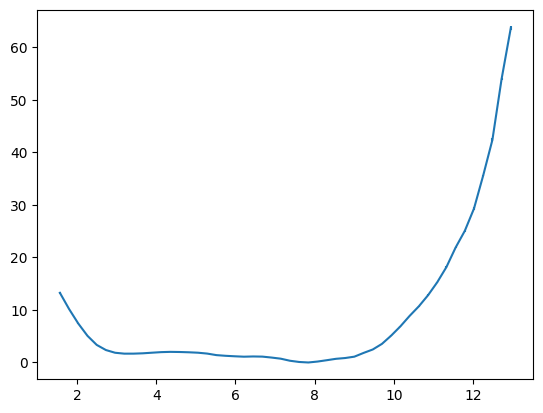

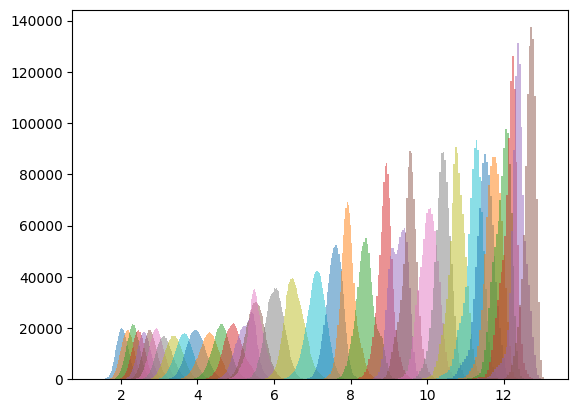

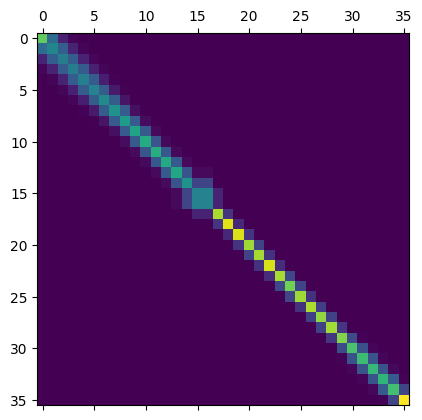

In [12]:
fileglob = '../_sim/0[5,9]*/_output/pmd_prod_pBhreus*.txt'
dG_pB = ARW_FE_analysis(fileglob, [1], 300, 50)
dG_pB.read_cvdata_from_pmdout()
dG_pB.calc_free_energies(decorrelationRequired=True, minimumIndependentCVs=100, showBSEplots=False)
dG_pB.create_PMF(show_pmf=True)
dG_pB.plot_histograms()
dG_pB_overlap = dG_pB.compute_overlap_matrix()
dG_pB.calc_PMFcontribution(1, 10)

## $ \Delta G^\text{B}_\text{n}$

reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus1.0.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus1.9.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus3.1.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus5.5.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus2.8.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus5.2.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus3.7.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus4.3.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus1.6.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBhreus3.4.txt
reading file with the filename ../_sim/06_TIP3P_med_rnaBulk/_output/pmd_prod_nBh

/tmp/ipykernel_781668/1429714341.py:68: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0))) #### For multicolumn, make sure to understand ziplongest(*list), because it is important how it handles CV_rawlist from 3 pandas columns
/tmp/ipykernel_781668/1429714341.py:125: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a


Correlation time for set 0 is 67


/tmp/ipykernel_781668/1429714341.py:128: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 1 is 45
Correlation time for set 2 is 40


/tmp/ipykernel_781668/1429714341.py:128: RuntimeWarning: overflow encountered in multiply
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3
/tmp/ipykernel_781668/1429714341.py:128: RuntimeWarning: invalid value encountered in divide
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 3 is 27
Correlation time for set 4 is 32
Correlation time for set 5 is 49
Correlation time for set 6 is 75
Correlation time for set 7 is 85
Correlation time for set 8 is 71
Correlation time for set 9 is 112
Correlation time for set 10 is 108
Correlation time for set 11 is 111
Correlation time for set 12 is 151
Correlation time for set 13 is 127
Correlation time for set 14 is 101
Correlation time for set 15 is 221
[0.9    1.0066 1.1132 1.2198 1.3264 1.433  1.5396 1.6462 1.7528 1.8594
 1.966  2.0726 2.1792 2.2858 2.3924 2.499  2.6056 2.7122 2.8188 2.9254
 3.032  3.1386 3.2452 3.3518 3.4584 3.565  3.6716 3.7782 3.8848 3.9914
 4.098  4.2046 4.3112 4.4178 4.5244 4.631  4.7376 4.8442 4.9508 5.0574
 5.164  5.2706 5.3772 5.4838 5.5904 5.697  5.8036 5.9102 6.0168 6.1234
 6.23  ] {'bin_edges': array([0.9   , 1.0066, 1.1132, 1.2198, 1.3264, 1.433 , 1.5396, 1.6462,
       1.7528, 1.8594, 1.966 , 2.0726, 2.1792, 2.2858, 2.3924, 2.499 ,
       2.6056, 2.7122, 2.8188, 2.9254,

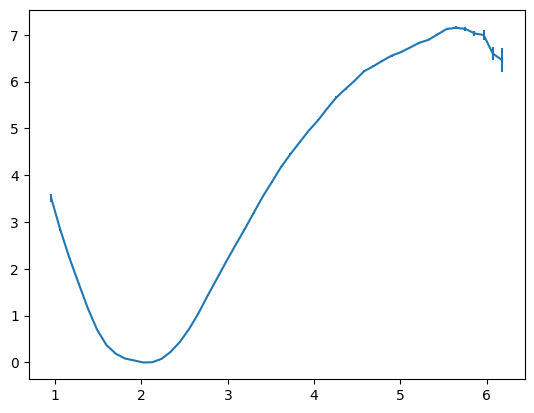

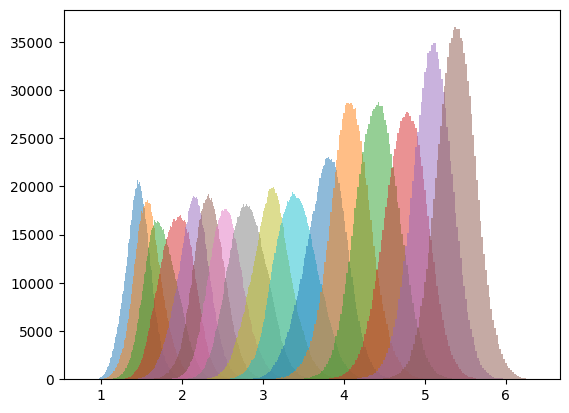

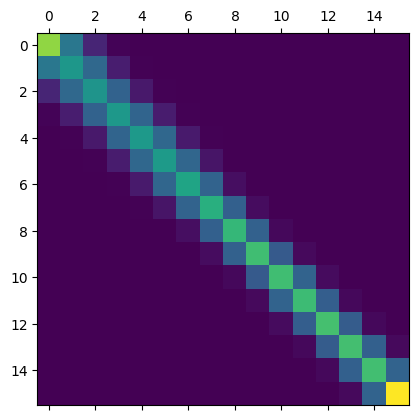

In [47]:
fileglob = '../_sim/06*/_output/pmd_prod_nBhreus*.txt'
dG_nB = ARW_FE_analysis(fileglob, [1], 300, 50)
dG_nB.read_cvdata_from_pmdout()
dG_nB.calc_free_energies(decorrelationRequired=True, minimumIndependentCVs=100, showBSEplots=False)
dG_nB.create_PMF(show_pmf=True)
dG_nB.plot_histograms()
dG_nB_overlap = dG_nB.compute_overlap_matrix()
dG_nB.calc_PMFcontribution(1, 10)

In [48]:
dG_nB.PMFcontribution

2.920629774264241

## $ \Delta G^\text{S}_\text{p}$

reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_.txt
reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_p.txt


/tmp/ipykernel_781668/3273150791.py:69: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0))) #### For multicolumn, make sure to understand ziplongest(*list), because it is important how it handles CV_rawlist from 3 pandas columns
/tmp/ipykernel_781668/3273150791.py:126: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a


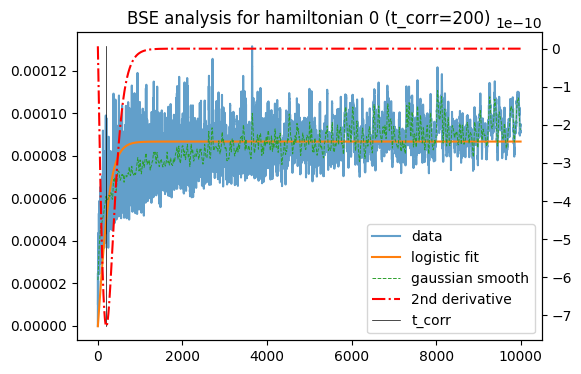

Correlation time for set 0 is 200


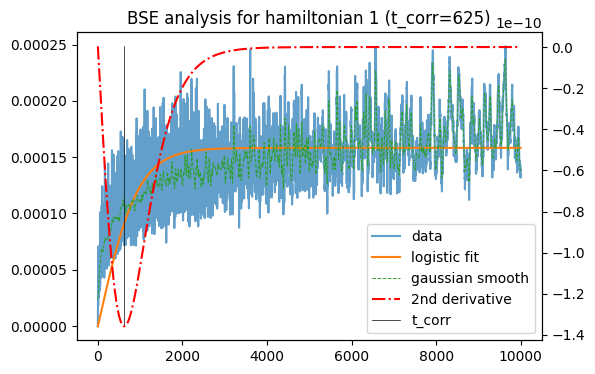

Correlation time for set 1 is 625


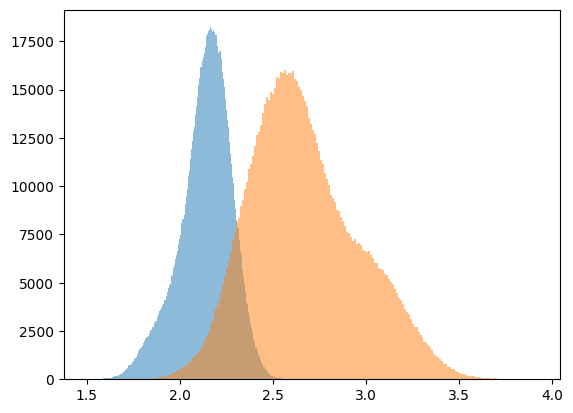

[[ 0.         -8.98686884]
 [ 8.98686884  0.        ]] [[0.         0.02586563]
 [0.02586563 0.        ]]


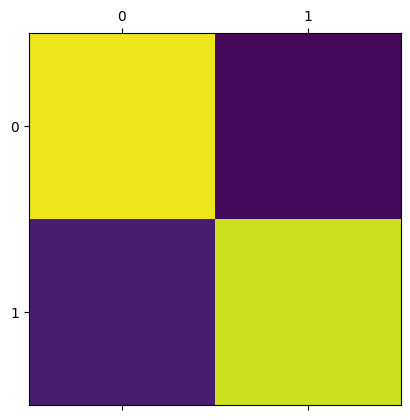

In [15]:
fileglob = '../_sim/01*/_output/pmd*[!noa].txt'
dG_pS = ARW_FE_analysis(fileglob, [1], 300, 100)
dG_pS.read_cvdata_from_pmdout()
F_pS, dF_pS = dG_pS.calc_MBAR_free_energy_differences(decorrelationRequired=True, minimumIndependentCVs=100)
dG_pS.plot_histograms()
dG_pS_overlap = dG_pS.compute_overlap_matrix()
print(F_pS, dF_pS)

## $ \Delta G^\text{S}_\text{n}$

reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_p.txt
reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_pn.txt


/tmp/ipykernel_781668/3273150791.py:69: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0))) #### For multicolumn, make sure to understand ziplongest(*list), because it is important how it handles CV_rawlist from 3 pandas columns


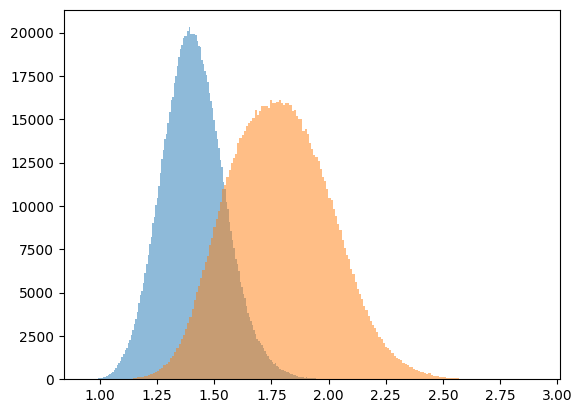

[[ 0.         -1.59222173]
 [ 1.59222173  0.        ]] [[0.         0.00460271]
 [0.00460271 0.        ]]


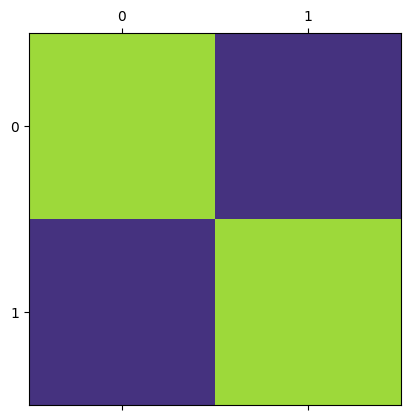

In [16]:
fileglob = '../_sim/01*/_output/pmd_*[!oa].txt'
dG_nS = ARW_FE_analysis(fileglob, [2], 300, 100)
dG_nS.read_cvdata_from_pmdout()
F_nS, dF_nS = dG_nS.calc_MBAR_free_energy_differences(decorrelationRequired=True, correlationTimeEstimate=50, minimumIndependentCVs=100)
dG_nS.plot_histograms()
dG_nS_overlap = dG_nS.compute_overlap_matrix()
print(F_nS, dF_nS)

## $ \Delta G^\text{S}_\text{o}$

reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_pno.txt
reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_pn.txt


/tmp/ipykernel_781668/3273150791.py:116: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


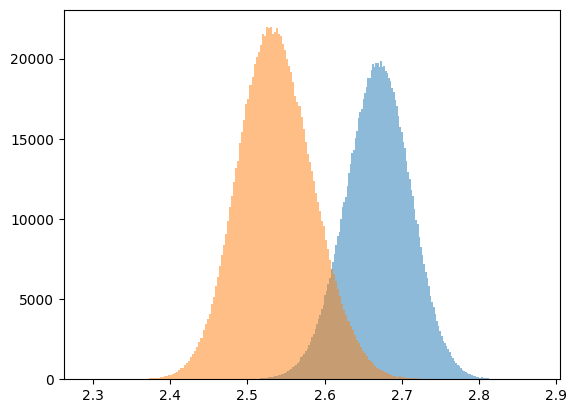

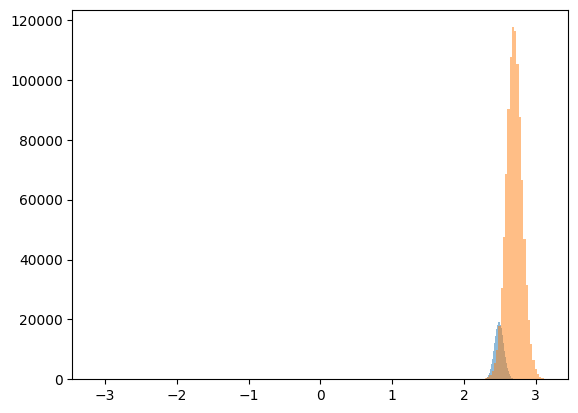

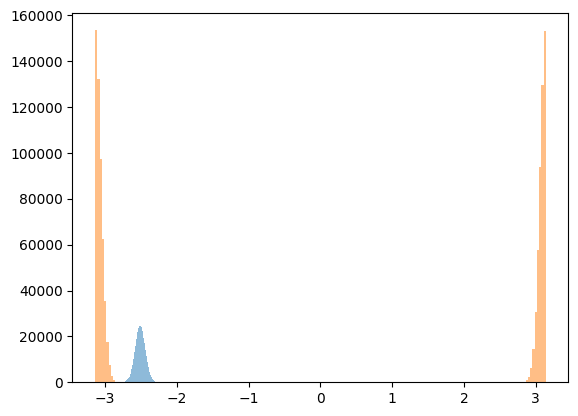

/tmp/ipykernel_781668/3273150791.py:126: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a
/tmp/ipykernel_781668/3273150791.py:129: RuntimeWarning: overflow encountered in power
  return -a * k**2 * (np.exp(k*(x-1)) - 1) * np.exp(k*(x-1)) / (np.exp(k*(x-1)) + 1)**3


Correlation time for set 0 is 47
Correlation time for set 1 is 47
Correlation time for set 2 is 41
Correlation time for set 3 is 68
Correlation time for set 4 is 156
Correlation time for set 5 is 97


[[  0.         -20.48056303]
 [ 20.48056303   0.        ]] [[0.         0.34935937]
 [0.34935937 0.        ]]


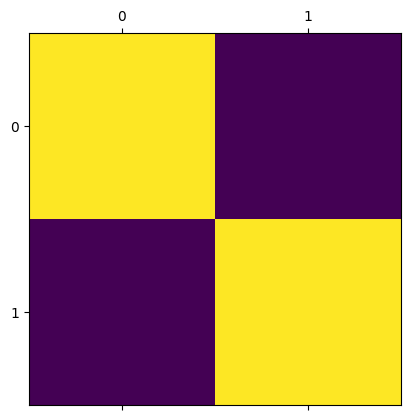

In [17]:
fileglob = '../_sim/01*/_output/pmd_p*[!a].txt'
dG_oS = ARW_FE_analysis(fileglob, [3,4,5], 300, 100)
dG_oS.read_cvdata_from_pmdout()
dG_oS.plot_histograms(angularData=False)
F_oS, dF_oS = dG_oS.calc_MBAR_free_energy_differences_MultiCV(decorrelationRequired=True,
                                                angularData=True,
                                                minimumIndependentCVs=100,
                                                showBSEplots=False)
MbarOverlap = dG_oS.compute_overlap_matrix()
print(F_oS, dF_oS)

## $ \Delta G^\text{S}_\text{a}$

reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_pnoa.txt
reading file with the filename ../_sim/01_TIP3P_med_site/_output/pmd_pno.txt


/tmp/ipykernel_781668/3273150791.py:116: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0)))


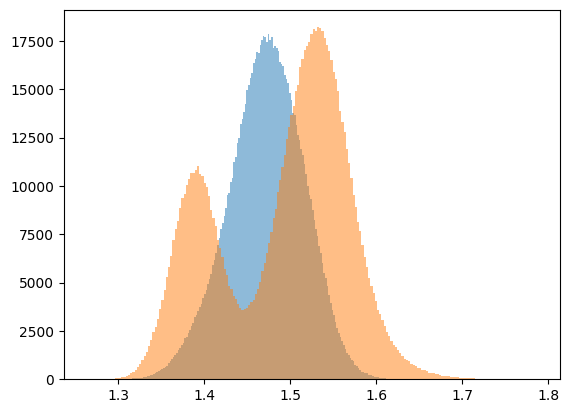

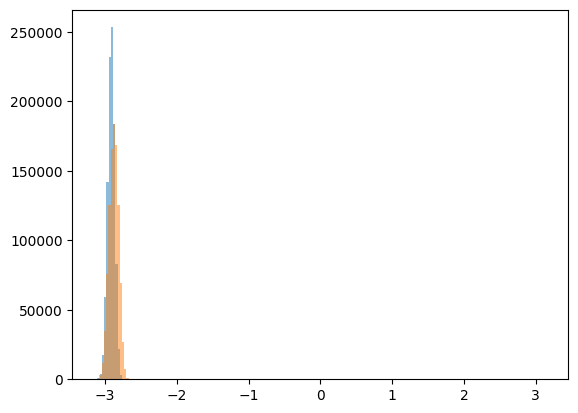

/tmp/ipykernel_781668/3273150791.py:126: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a


Correlation time for set 0 is 201
Correlation time for set 1 is 147
Correlation time for set 2 is 260
Correlation time for set 3 is 213
[[ 0.         -2.60914643]
 [ 2.60914643  0.        ]] [[0.         0.00905943]
 [0.00905943 0.        ]]


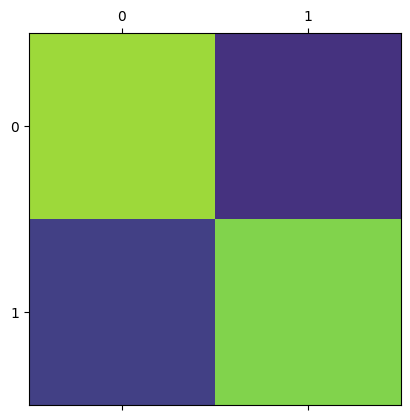

In [18]:
fileglob = '../_sim/01*/_output/pmd_pno*.txt'
dG_aS = ARW_FE_analysis(fileglob, [6,7], 300, 100)
dG_aS.read_cvdata_from_pmdout()
dG_aS.plot_histograms(angularData=False)
F_aS, dF_aS = dG_aS.calc_MBAR_free_energy_differences_MultiCV(decorrelationRequired=True,
                                                angularData=True,
                                                minimumIndependentCVs=100,
                                                showBSEplots=False)
MbarOverlap = dG_aS.compute_overlap_matrix()
print(F_aS, dF_aS)

## $ \Delta G^\text{B}_\text{o}$

## $ S^*$

## $ I^*$

reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus14.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus13.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus28.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus26.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus21.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus30.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus37.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus39.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus20.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_output/pmd_prod_hreus27.txt
reading file with the filename ../_sim/08_TIP3P_med_HREUS_K=3.5/_outpu

/tmp/ipykernel_781668/2843390665.py:69: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.Hamiltonians_CVs = np.column_stack((itertools.zip_longest(*CV_rawlist, fillvalue=0))) #### For multicolumn, make sure to understand ziplongest(*list), because it is important how it handles CV_rawlist from 3 pandas columns
/tmp/ipykernel_781668/2843390665.py:126: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-k * (x - 1)))-0.5*a


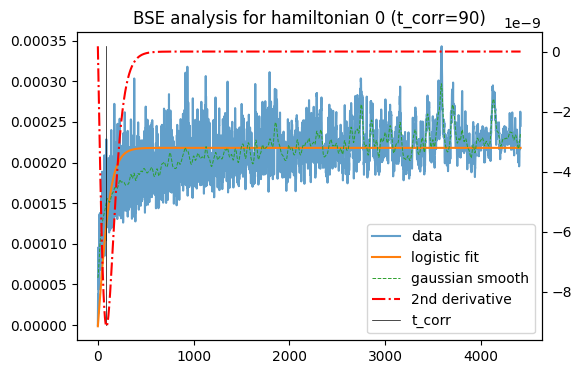

Correlation time for set 0 is 90


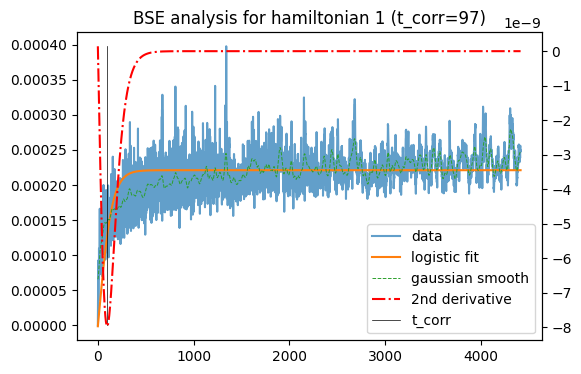

Correlation time for set 1 is 97


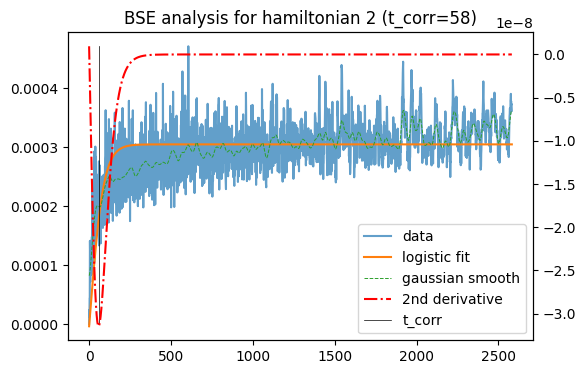

Correlation time for set 2 is 58


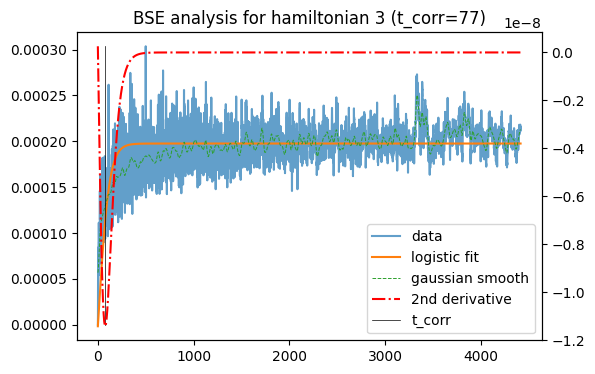

Correlation time for set 3 is 77


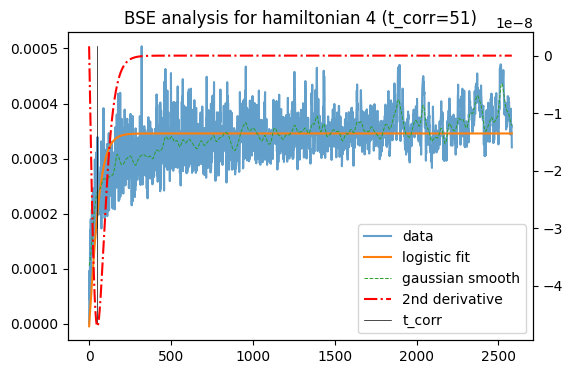

Correlation time for set 4 is 51


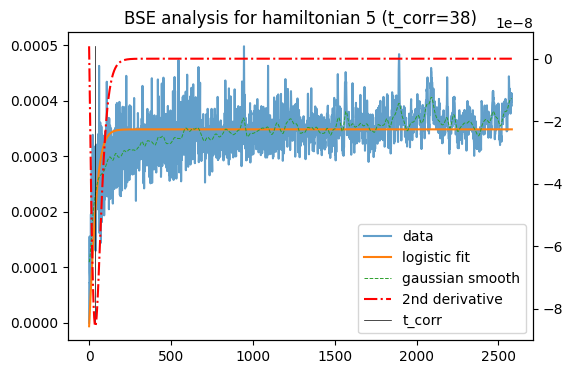

Correlation time for set 5 is 38


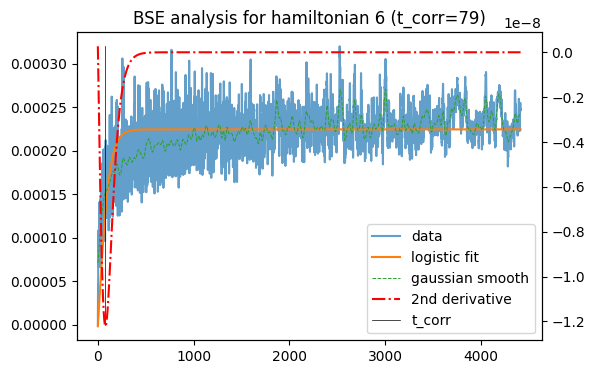

Correlation time for set 6 is 79


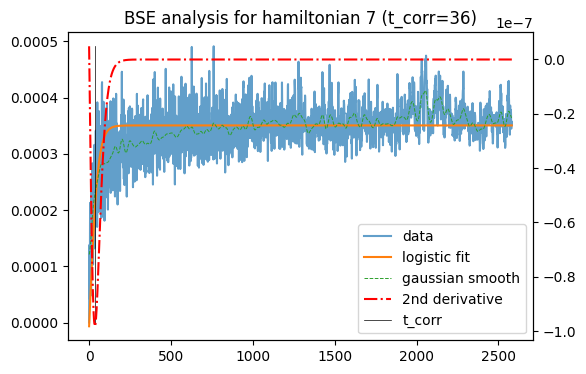

Correlation time for set 7 is 36


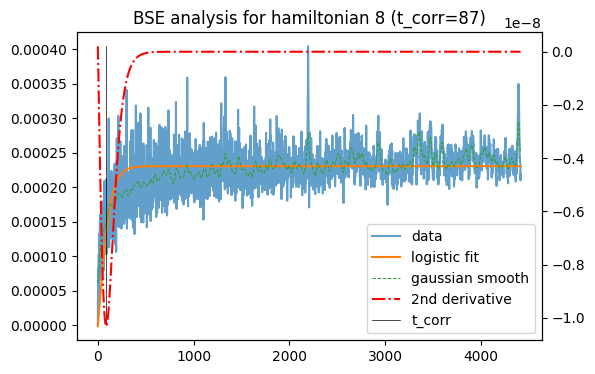

Correlation time for set 8 is 87


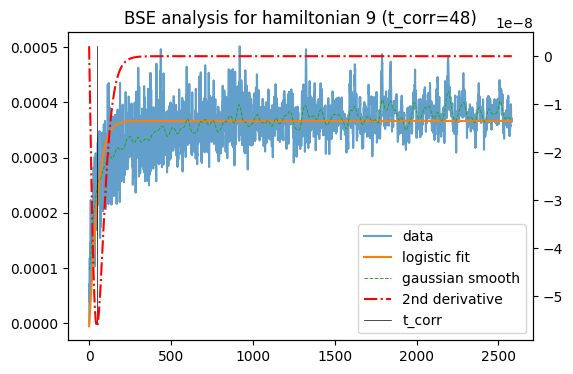

Correlation time for set 9 is 48


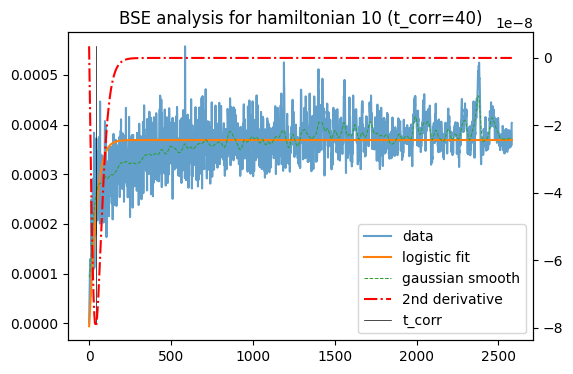

Correlation time for set 10 is 40


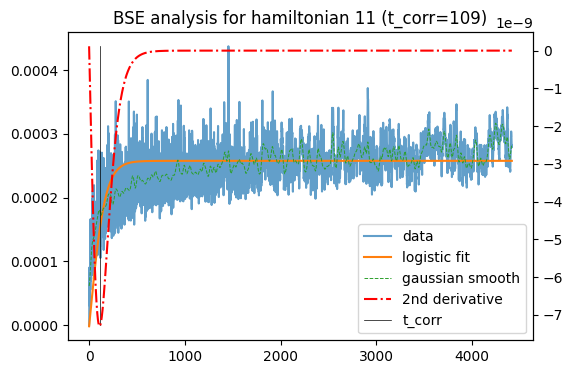

Correlation time for set 11 is 109


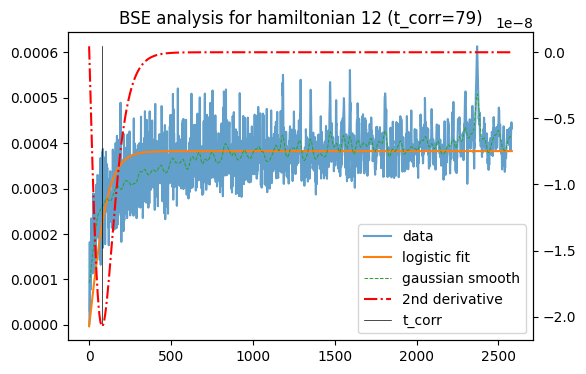

Correlation time for set 12 is 79


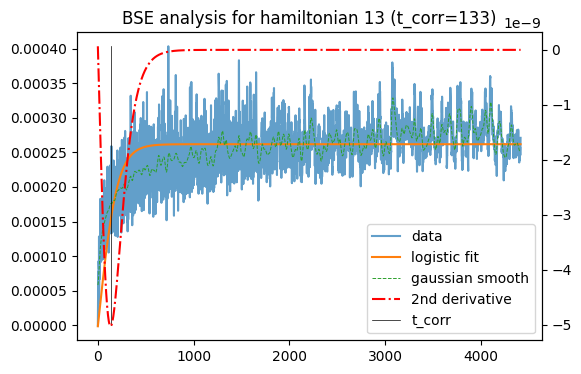

Correlation time for set 13 is 133


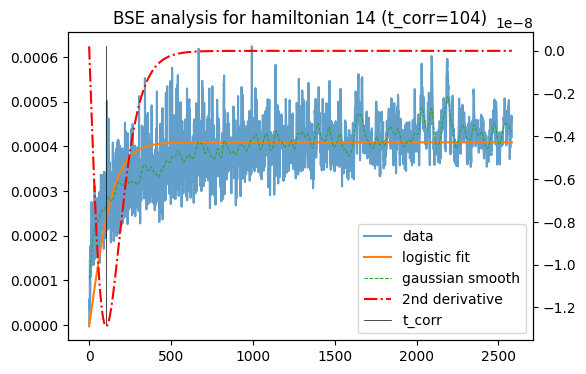

Correlation time for set 14 is 104


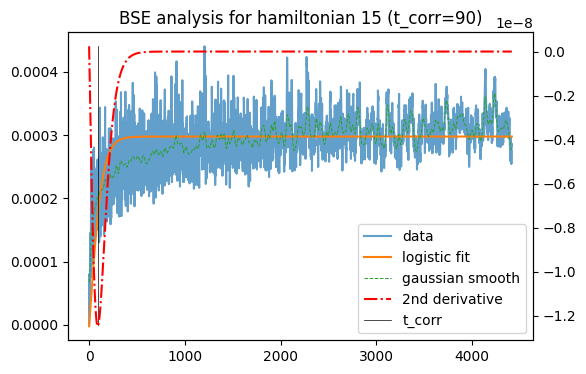

Correlation time for set 15 is 90


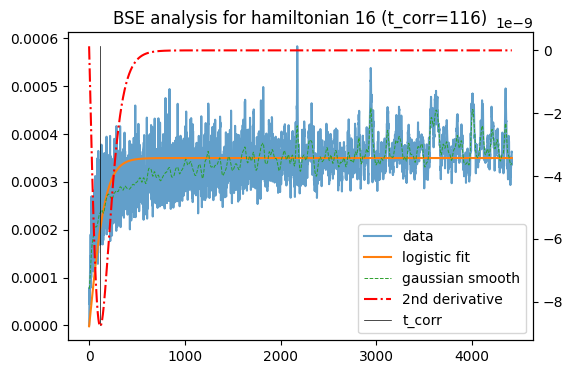

Correlation time for set 16 is 116


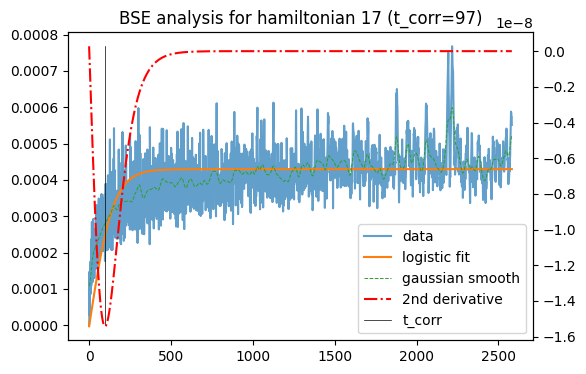

Correlation time for set 17 is 97


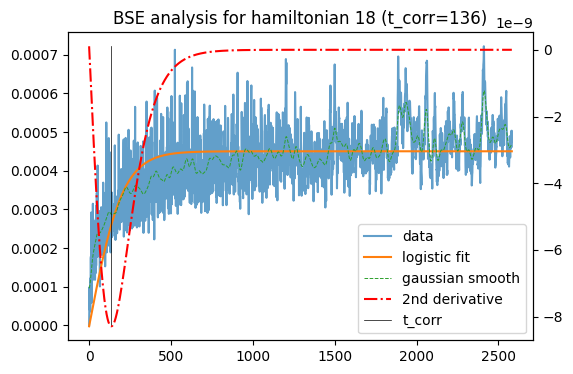

Correlation time for set 18 is 136


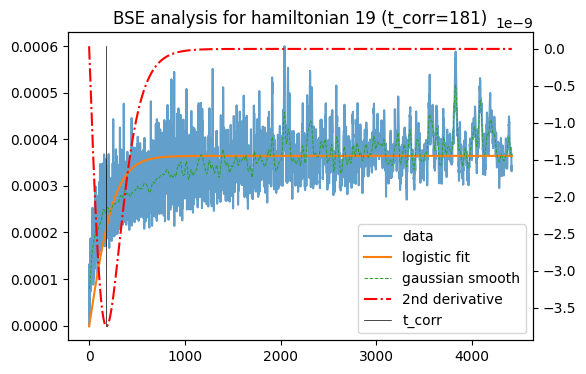

Correlation time for set 19 is 181


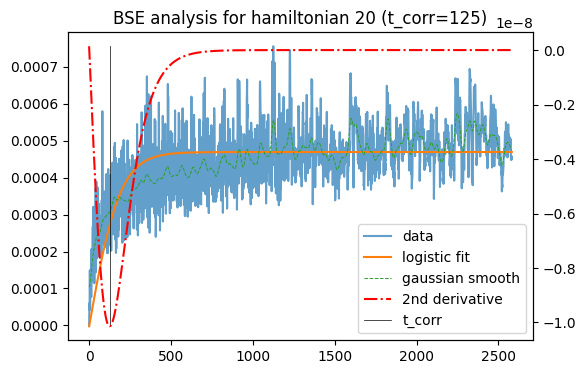

Correlation time for set 20 is 125


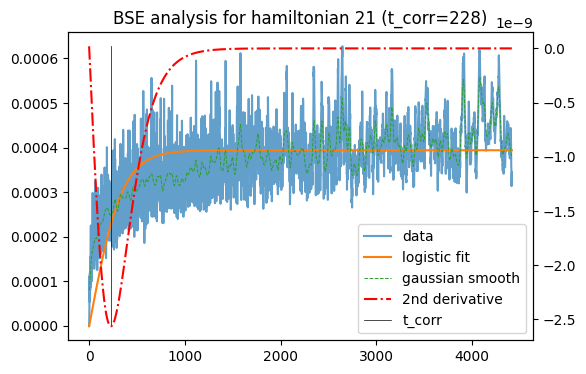

Correlation time for set 21 is 228


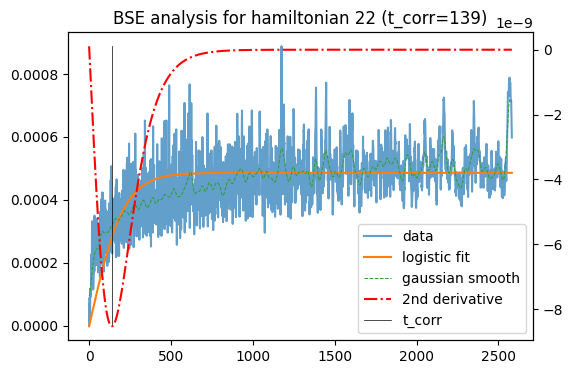

Correlation time for set 22 is 139


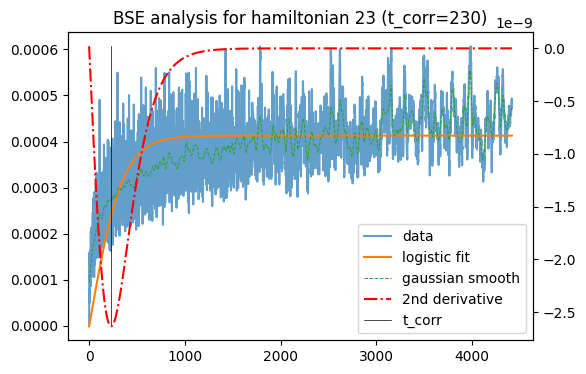

Correlation time for set 23 is 230


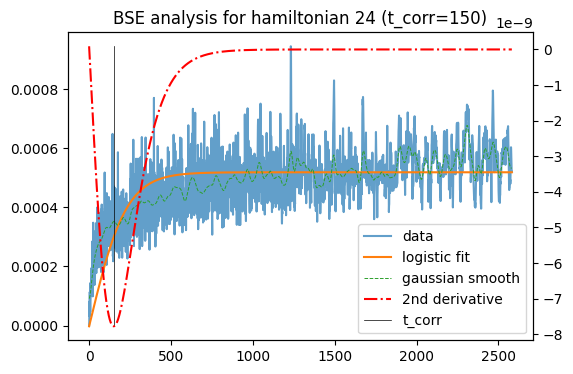

Correlation time for set 24 is 150


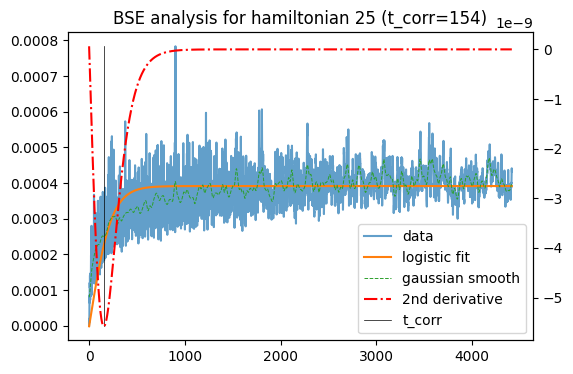

Correlation time for set 25 is 154


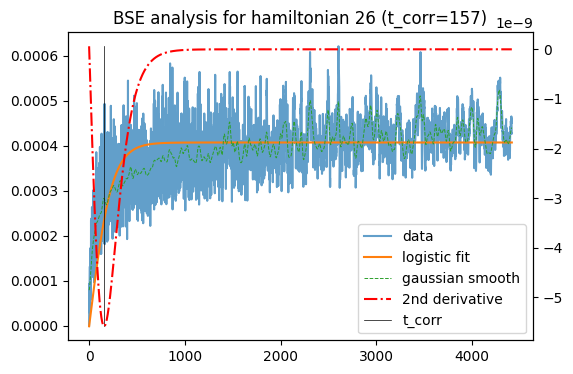

Correlation time for set 26 is 157


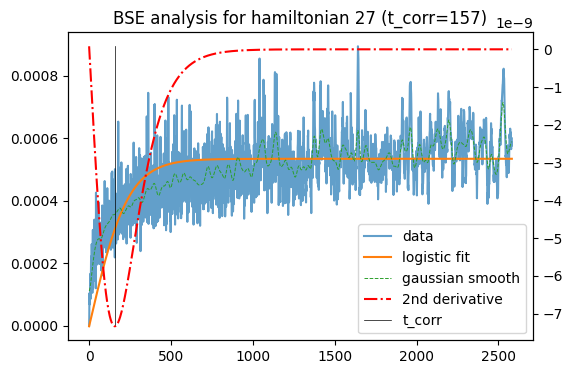

Correlation time for set 27 is 157


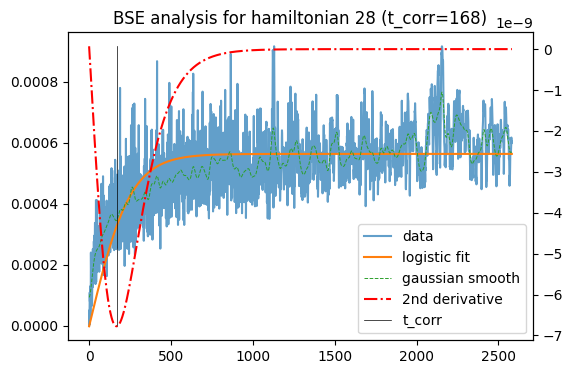

Correlation time for set 28 is 168


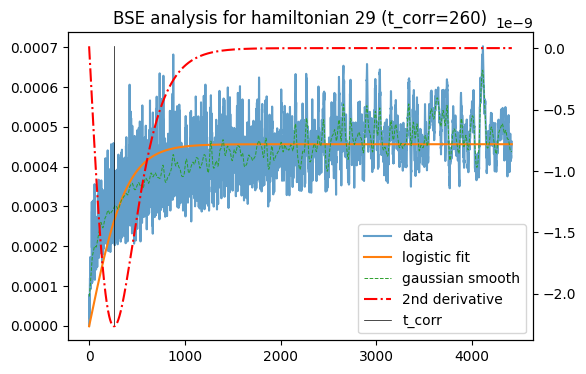

Correlation time for set 29 is 260


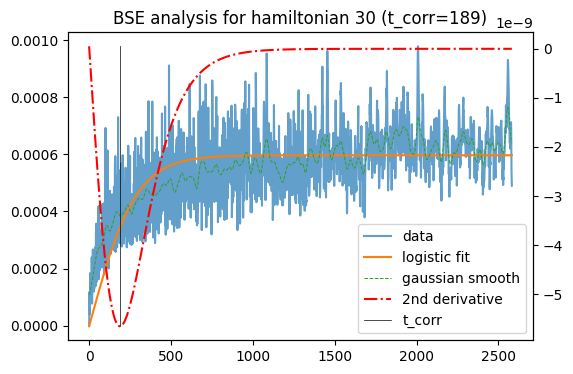

Correlation time for set 30 is 189


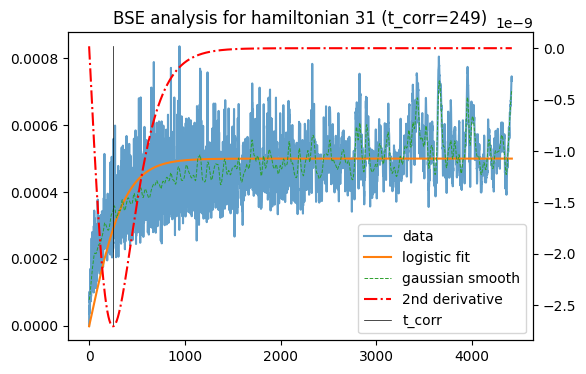

Correlation time for set 31 is 249


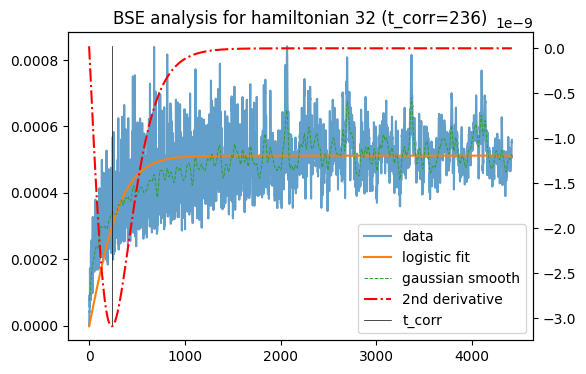

Correlation time for set 32 is 236


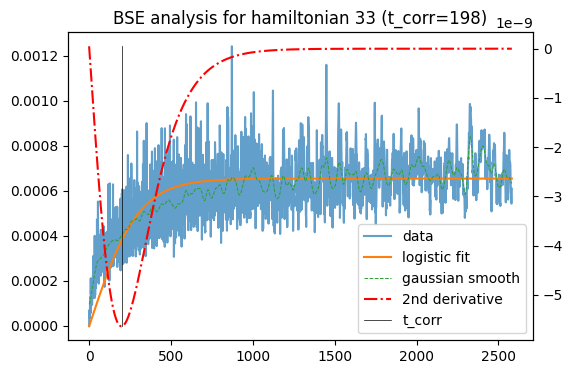

Correlation time for set 33 is 198


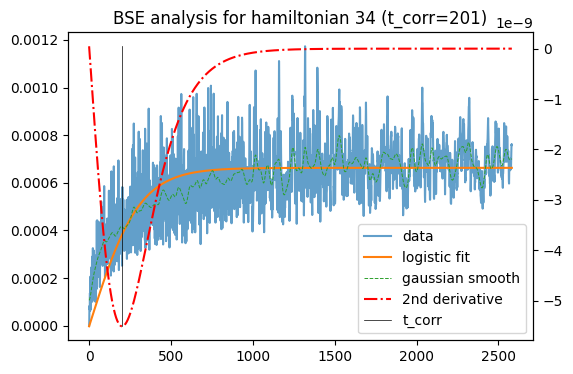

Correlation time for set 34 is 201


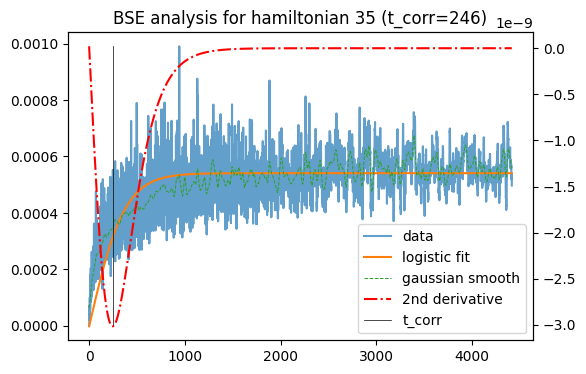

Correlation time for set 35 is 246


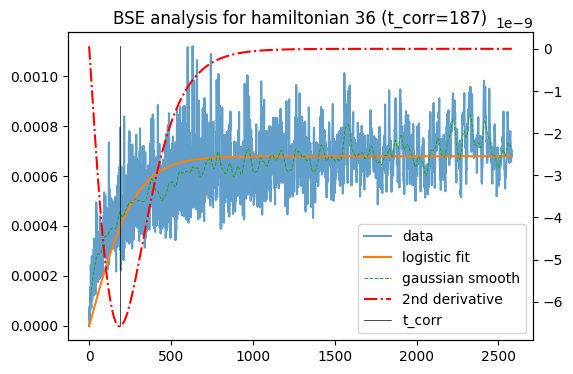

Correlation time for set 36 is 187


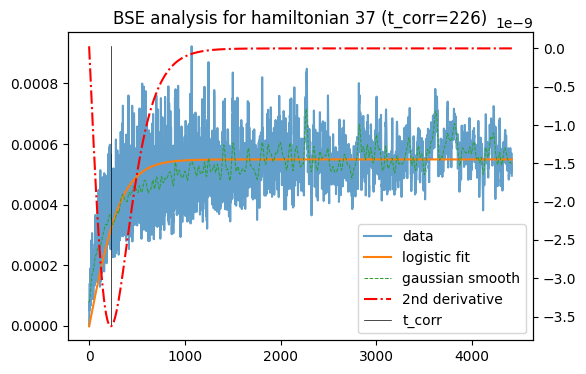

Correlation time for set 37 is 226


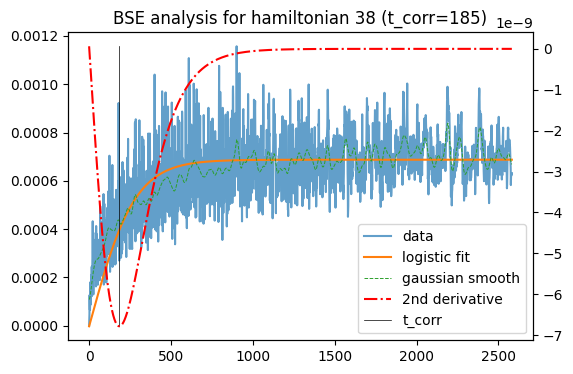

Correlation time for set 38 is 185


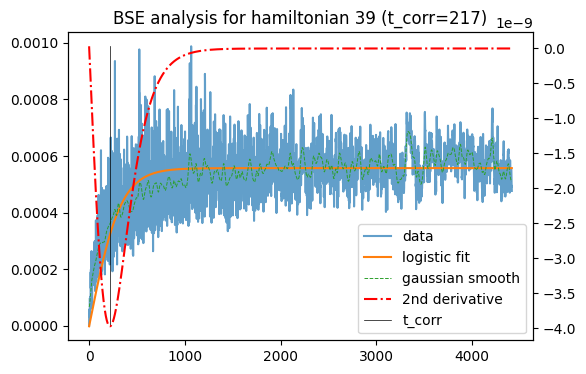

Correlation time for set 39 is 217


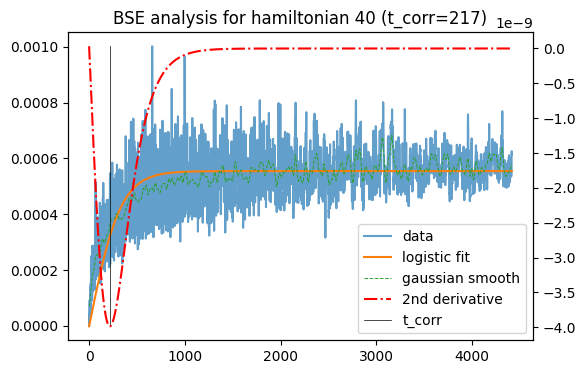

Correlation time for set 40 is 217


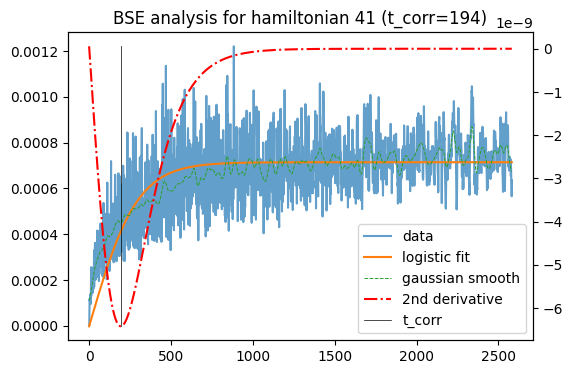

Correlation time for set 41 is 194


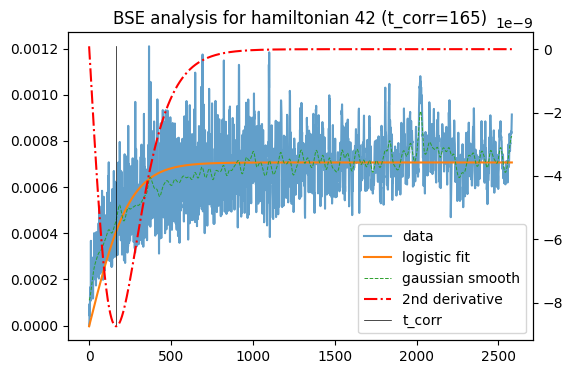

Correlation time for set 42 is 165


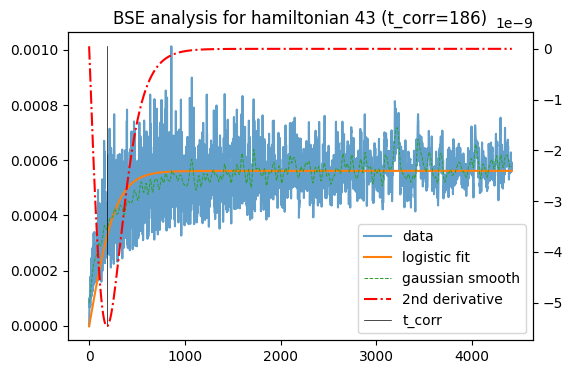

Correlation time for set 43 is 186


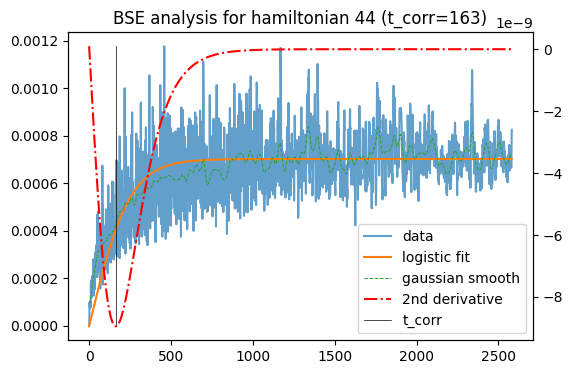

Correlation time for set 44 is 163


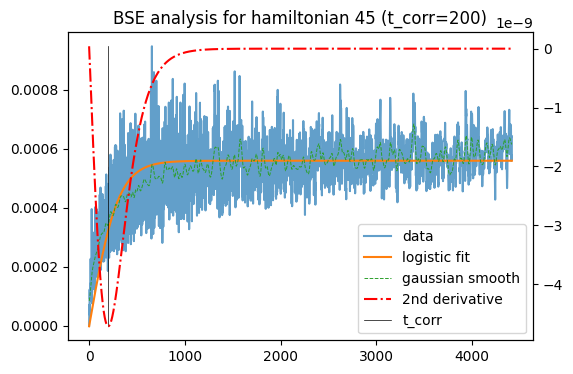

Correlation time for set 45 is 200


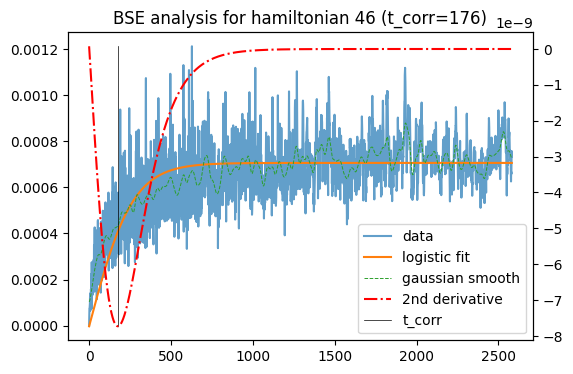

Correlation time for set 46 is 176


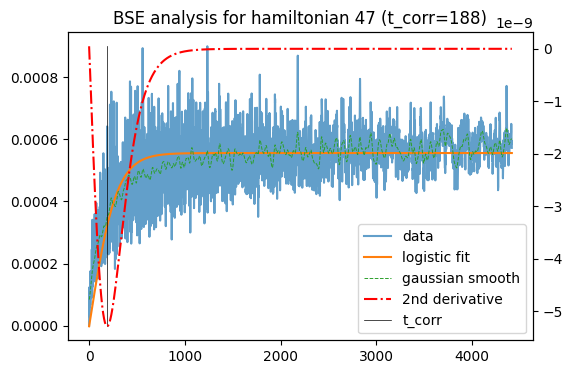

Correlation time for set 47 is 188


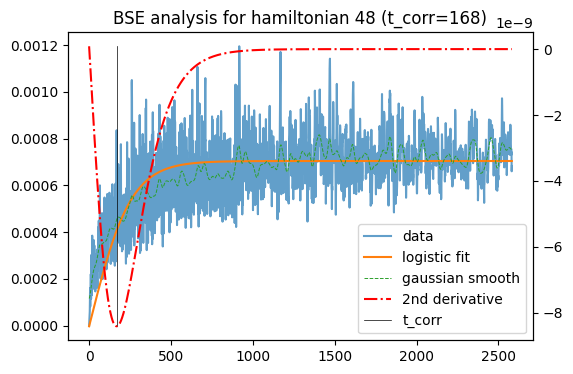

Correlation time for set 48 is 168


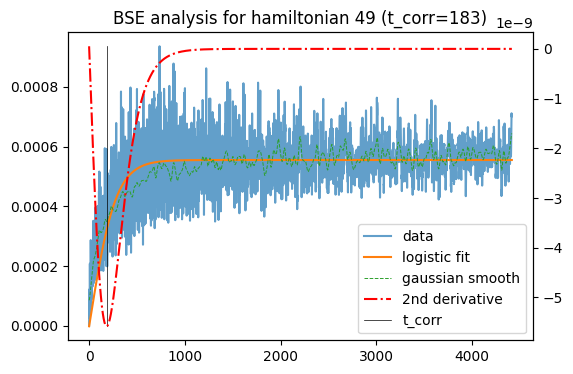

Correlation time for set 49 is 183


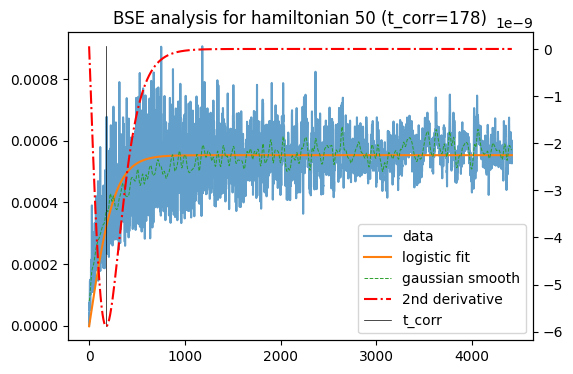

Correlation time for set 50 is 178


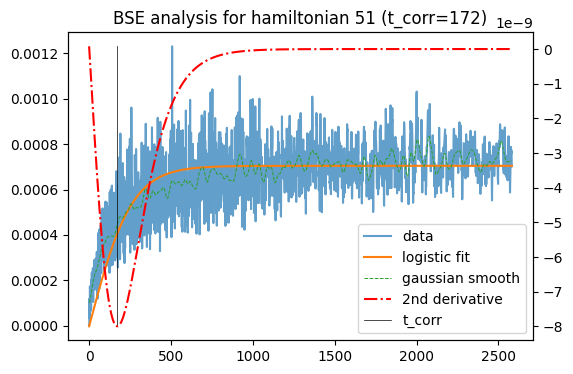

Correlation time for set 51 is 172


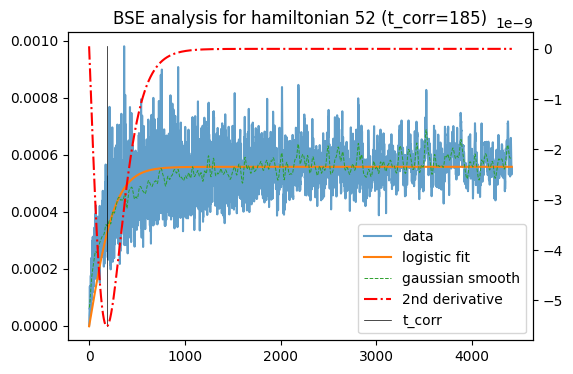

Correlation time for set 52 is 185


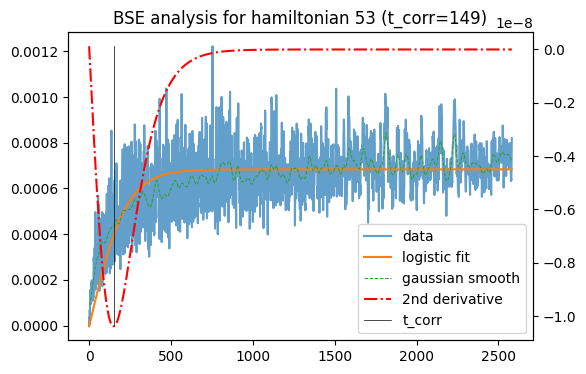

Correlation time for set 53 is 149


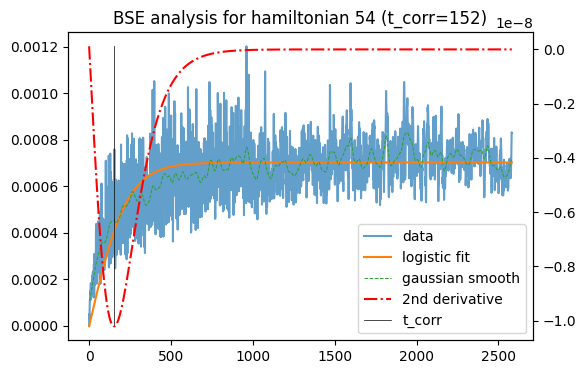

Correlation time for set 54 is 152


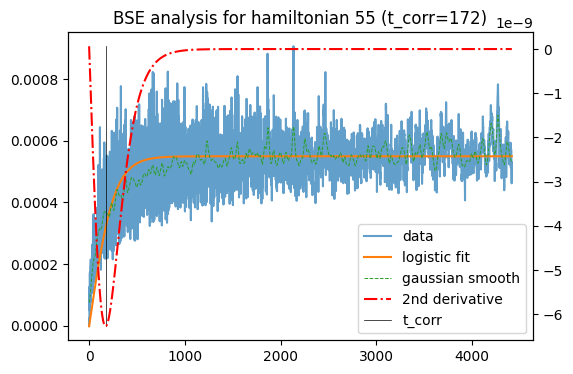

Correlation time for set 55 is 172


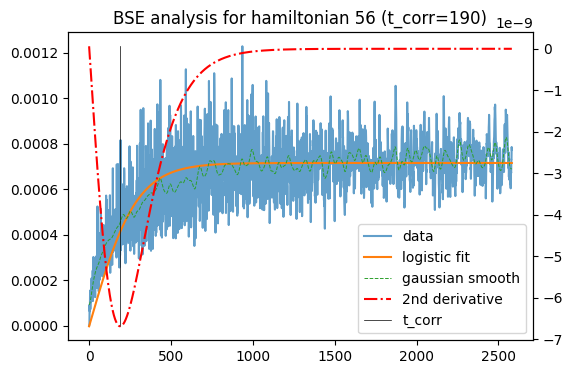

Correlation time for set 56 is 190


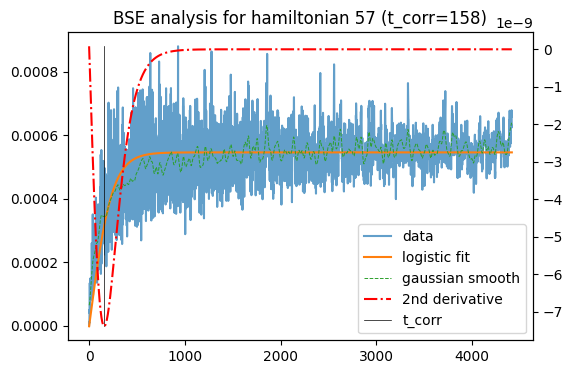

Correlation time for set 57 is 158


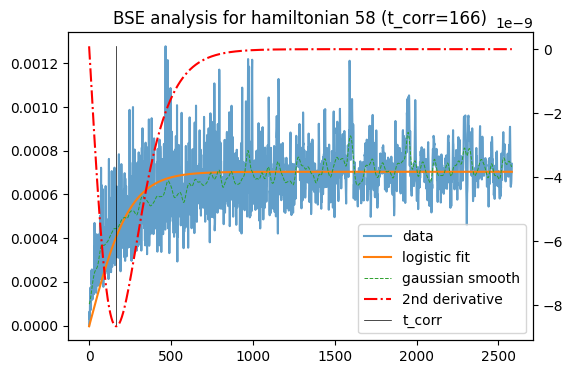

Correlation time for set 58 is 166


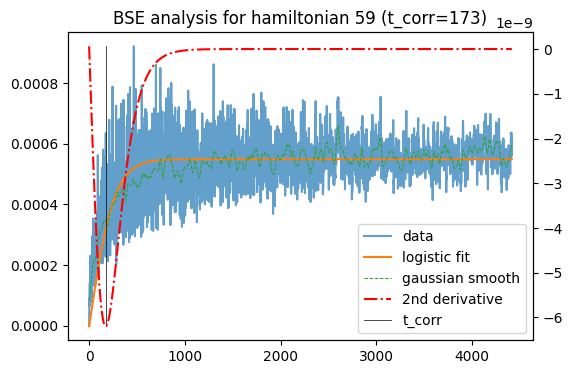

Correlation time for set 59 is 173


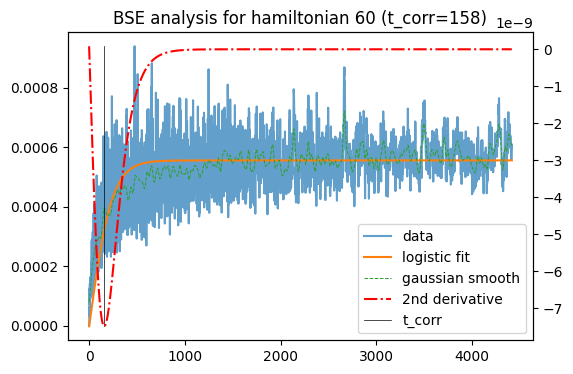

Correlation time for set 60 is 158


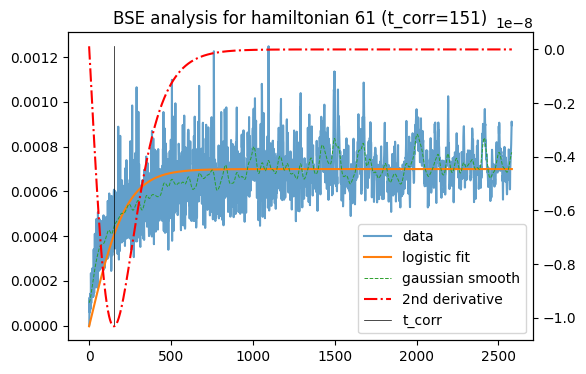

Correlation time for set 61 is 151


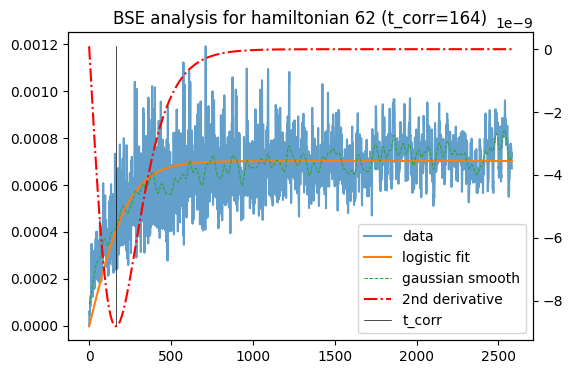

Correlation time for set 62 is 164


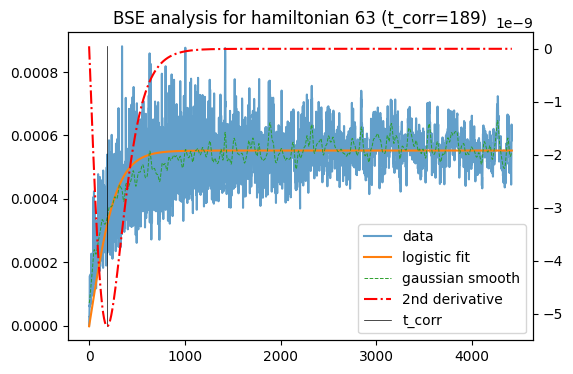

Correlation time for set 63 is 189
FES succesfully calculated


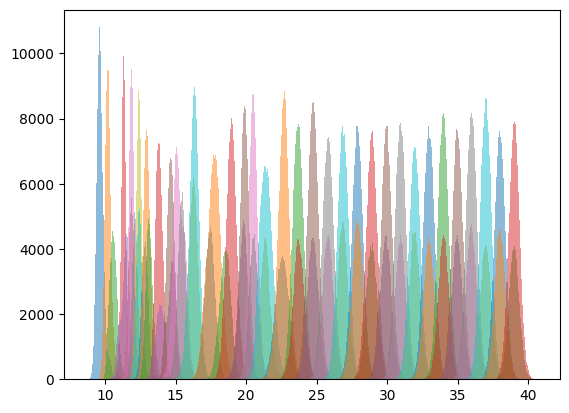

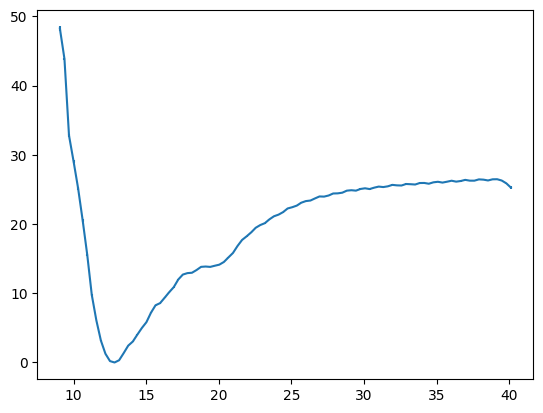

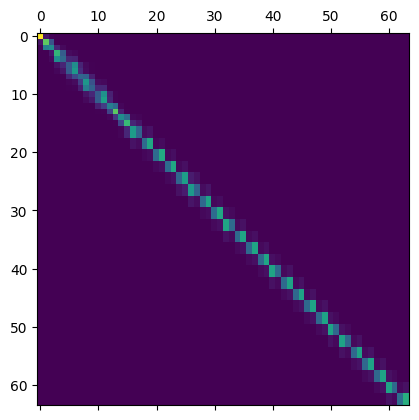

In [24]:
fileglob = '../_sim/0[7,8]*/_output/pmd_prod_hreus*.txt'
Istar = ARW_FE_analysis(fileglob, [8], 300, 100)
Istar.read_cvdata_from_pmdout()
Istar.calc_free_energies(decorrelationRequired=True, minimumIndependentCVs=100, showBSEplots=True)
Istar.plot_histograms()
Istar.create_PMF(show_pmf=True)
Istar_overlap = Istar.compute_overlap_matrix()

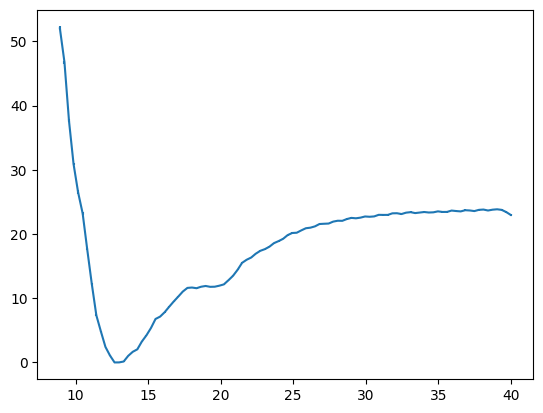

3.4097702658386092e+16

In [33]:
def calculate_I_star(self, site_r=None, show_pmf=True):
    
    if site_r==None:
        print("site_r is None but should be the cut-off, where binding site ends and the bulk region starts")
    
    comdist, F, dF = create_PMF(self, show_pmf=show_pmf)
    site_id = np.where(comdist > site_r)[0][0]
    comdist[site_id]

    W_site = F[site_id]
    W_PMF = F[:site_id]

    integrand = np.exp(-np.mean(self.beta_H)*(W_PMF - W_site))
    I_star = integrate.trapz(integrand, self.bin_centers[:site_id])
    setattr(self,'I_star', I_star)
    

calculate_I_star(energies_US, site_r=30, show_pmf=True)

In [67]:
from scipy import integrate
import math
import numpy as np


site_r = 30
def integrand(theta, phi):
        
        k_phi = 100.0
        k_theta = 100.0
        
        theta0 = 1.27
        phi0 = -2.89
        
        u_theta = k_theta * (theta0 - theta)**2
        u_phi = k_phi * (phi0 - phi)**2
        
        return( math.sin(theta) * math.exp(-energies_US.beta_H[0] * (u_theta + u_phi)))

result, error = integrate.nquad(integrand, [[0, math.pi],
                                            [-math.pi,math.pi]])
S_star = site_r**2*result
dS_star = site_r**2*error




In [72]:
S_star * energies_US.I_star

5.48128449251595e+17